# Stock Forecast

In [2]:
import re
import os
import pandas as pd
import numpy as np
# Path to the folder containing the Excel files
#folder_path = r'H:\api_data\TCS_1hr'
folder_path = r'H:\time_series_models\nifty\1_hour_data'

# Function to extract the batch number from file names
def extract_batch_number(filename):
    match = re.search(r'batch_(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Get a list of all Excel files in the folder, sorted by batch number
excel_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx') or f.endswith('.xls')], key=extract_batch_number)

# Initialize an empty list to store dataframes
dfs = []

# Loop through each Excel file, read it, and append the dataframe to the list
for file in excel_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    # Ensure DateTime is parsed consistently across files
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs)

# Ensure 'DateTime' column is in datetime format and sort by it in ascending order (oldest to newest)
combined_df = combined_df.sort_values(by='DateTime', ascending=True)

# Reset the index after sorting
combined_df.reset_index(drop=True, inplace=True)

In [3]:
combined_df.head()

,DateTime,Open,High,Low,Close,Volume
0,2015-07-13 09:15:00,8397.25,8404.80,8362.20,8366.10,0
1,2015-07-13 10:15:00,8366.85,8375.85,8358.85,8363.15,0
2,2015-07-13 11:15:00,8362.95,8370.60,8355.40,8364.95,0
3,2015-07-13 12:15:00,8364.90,8461.20,8364.65,8444.20,0
4,2015-07-13 13:15:00,8444.15,8467.05,8442.15,8462.65,0


In [4]:
combined_df.tail()

,DateTime,Open,High,Low,Close,Volume
16625,2025-02-25 11:15:00,22566.20,22581.15,22544.85,22572.65,0
16626,2025-02-25 12:15:00,22572.40,22600.40,22566.05,22592.75,0
16627,2025-02-25 13:15:00,22592.90,22595.90,22571.25,22582.05,0
16628,2025-02-25 14:15:00,22582.30,22585.95,22546.25,22552.40,0
16629,2025-02-25 15:15:00,22554.55,22559.95,22513.90,22526.30,0


In [5]:
combined_df['DateTime'] = pd.to_datetime(combined_df['DateTime'])
combined_df = combined_df.set_index('DateTime')

split_date = pd.to_datetime('2025-02-21 09:15:00')
train_df = combined_df.loc[combined_df.index<split_date]
test_df = combined_df.loc[combined_df.index>=split_date]


In [7]:
train_df.tail()

,Open,High,Low,Close,Volume
DateTime,,,,,
2025-02-20 11:15:00,22911.20,22914.10,22879.05,22889.10,0
2025-02-20 12:15:00,22888.50,22908.80,22870.55,22878.25,0
2025-02-20 13:15:00,22878.05,22923.00,22875.75,22899.50,0
2025-02-20 14:15:00,22900.05,22923.85,22895.25,22917.15,0
2025-02-20 15:15:00,22916.20,22920.80,22905.00,22906.25,0


In [8]:
test_df.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2025-02-21 09:15:00,22857.2,22921.00,22759.35,22760.65,0
2025-02-21 10:15:00,22760.2,22798.00,22733.30,22767.95,0
2025-02-21 11:15:00,22768.0,22820.90,22746.80,22786.30,0
2025-02-21 12:15:00,22786.2,22824.45,22757.95,22776.70,0
2025-02-21 13:15:00,22775.3,22787.20,22720.30,22778.90,0


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

data = train_df[['Open', 'High', 'Low', 'Close']].copy()

data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

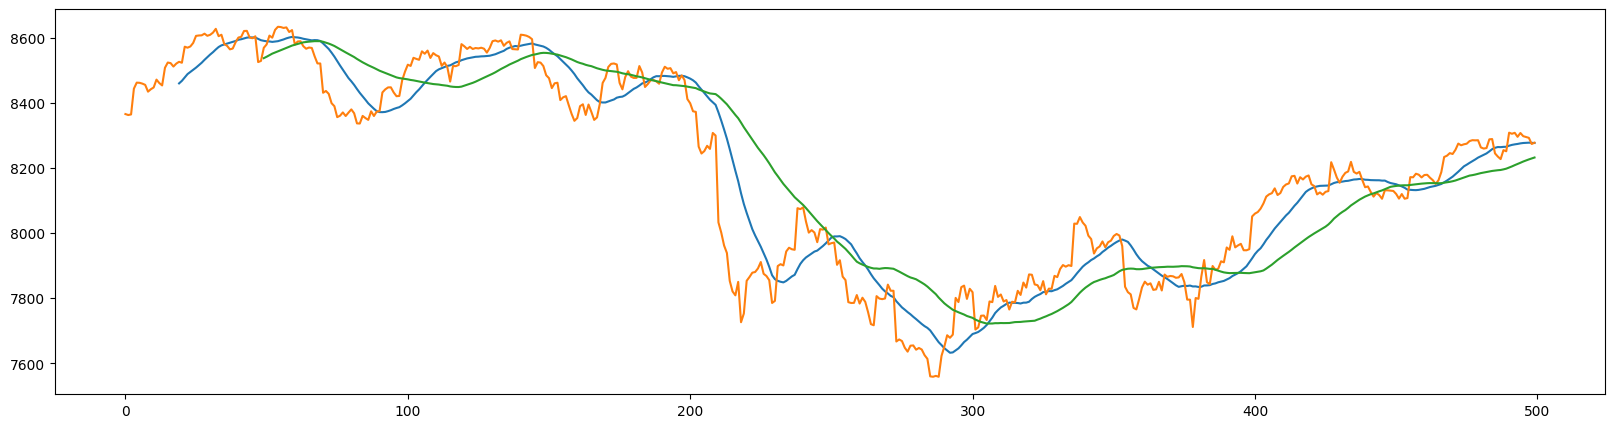

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(np.array(data['MA_20'][:500]))
plt.plot(np.array(data['Close'][:500]))
plt.plot(np.array(data['MA_50'][:500]))

In [18]:
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta>0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta<0, 0)).rolling(window=period).mean()
    rs = gain/loss
    return 100 - (100/(1+rs))

data["RSI"] = calculate_rsi(data['Close'])
data.dropna(inplace=True)

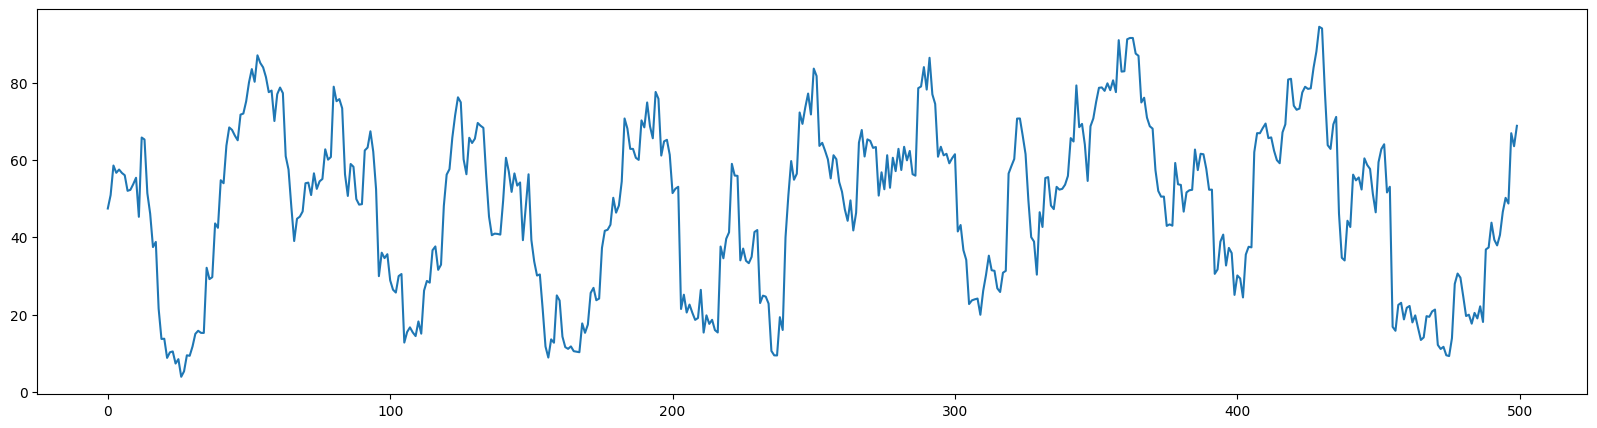

In [21]:
plt.figure(figsize=(20,5))
#plt.plot(np.array(data['MA_20'][:500]))
#plt.plot(np.array(data['Close'][:500]))
#plt.plot(np.array(data['MA_50'][:500]))
plt.plot(np.array(data['RSI'][:500]))

In [23]:
scalers = {}
for col in data.columns:
    scalers[col] = MinMaxScaler()
    data[col] = scalers[col].fit_transform(data[[col]])

input_seq = 35
output_seq = 7

def create_sequences(data, input_seq, output_seq):
    X, y = [], []
    for i in range(len(data) - input_seq - output_seq):
        X.append(data.iloc[i : i + input_seq].values)
        y.append(data.iloc[i + input_seq : i + input_seq + output_seq]['Close'].values)
    return np.array(X), np.array(y)

X, y = create_sequences(data, input_seq, output_seq)

In [28]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape = (input_seq, X.shape[2])),
    LSTM(32),
    Dense(output_seq)
])
model.compile(optimizer='adam', loss='mse')

epochs = 10
batch_size = 256
model.fit(X,y, epochs=epochs, batch_size=batch_size)


Epoch 1/10
65/65 [==============================] - 9s 12ms/step - loss: 0.0155
Epoch 2/10
65/65 [==============================] - 1s 11ms/step - loss: 2.4637e-04
Epoch 3/10
65/65 [==============================] - 1s 11ms/step - loss: 1.4495e-04
Epoch 4/10
65/65 [==============================] - 1s 11ms/step - loss: 9.6695e-05
Epoch 5/10
65/65 [==============================] - 1s 11ms/step - loss: 7.4511e-05
Epoch 6/10
65/65 [==============================] - 1s 11ms/step - loss: 6.5288e-05
Epoch 7/10
65/65 [==============================] - 1s 11ms/step - loss: 6.2557e-05
Epoch 8/10
65/65 [==============================] - 1s 11ms/step - loss: 5.9333e-05
Epoch 9/10
65/65 [==============================] - 1s 11ms/step - loss: 5.6469e-05
Epoch 10/10
65/65 [==============================] - 1s 11ms/step - loss: 5.5691e-05


In [30]:
last_sequence = X[-1].reshape(1, input_seq, X.shape[2])
forecast = model.predict(last_sequence)
forecast = scalers['Close'].inverse_transform(forecast)

1/1 [==============================] - 1s 534ms/step


In [32]:
forecast

array([[22989.738, 22984.418, 23004.127, 22944.215, 22932.531, 22995.17 ,
        22985.285]], dtype=float32)

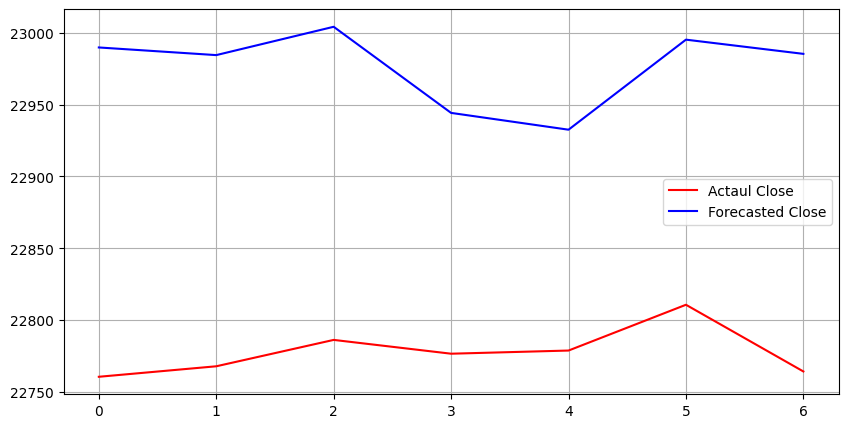

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(test_df['Close'][:7]), label='Actaul Close', color = 'r')
plt.plot(forecast.flatten(), label='Forecasted Close', color = 'blue')
plt.legend()
plt.grid()
plt.show()